In [1]:
import os
from typing import List, Sequence

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
def show_image(image, name=None, color=None, cmap=None):
    img = image
    if color is not None:
        img = cv.cvtColor(image, color)
    if name is not None:
        plt.title(name)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

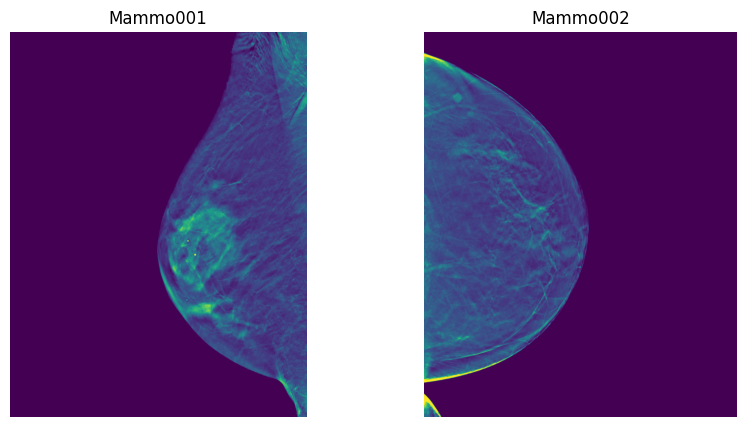

In [3]:
def read_images() -> (np.ndarray, np.ndarray):
    path = os.path.join(os.pardir, os.pardir, os.pardir, 'img', 'classification')
    img1 = cv.imread(os.path.join(path, 'Mammo001.png'), cv.IMREAD_COLOR)
    img2 = cv.imread(os.path.join(path, 'Mammo002.png'), cv.IMREAD_COLOR)
    return img1, img2

image1, image2 = read_images()
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Mammo001')
ax[1].imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Mammo002')
plt.show()

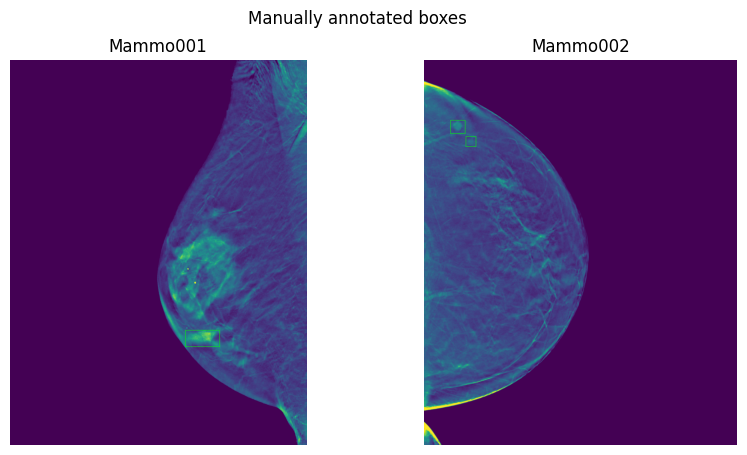

In [4]:
# Draw the given boxes on the images
def draw_boxes(image: np.ndarray, point: tuple[int, int], width: int, height: int) -> np.ndarray:
    img = image.copy()
    # Color in BGR
    color = (0, 255, 0)
    cv.rectangle(img, point, (point[0] + width, point[1] + height), color, 2)
    return img

image1_box = draw_boxes(image1, (1116, 1724), 218, 105)
image2_box = draw_boxes(image2, (267, 488), 64, 64)
image2_box = draw_boxes(image2_box, (169, 384), 93, 85)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(image1_box, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Mammo001')
ax[1].imshow(cv.cvtColor(image2_box, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Mammo002')
plt.suptitle('Manually annotated boxes')
plt.show()

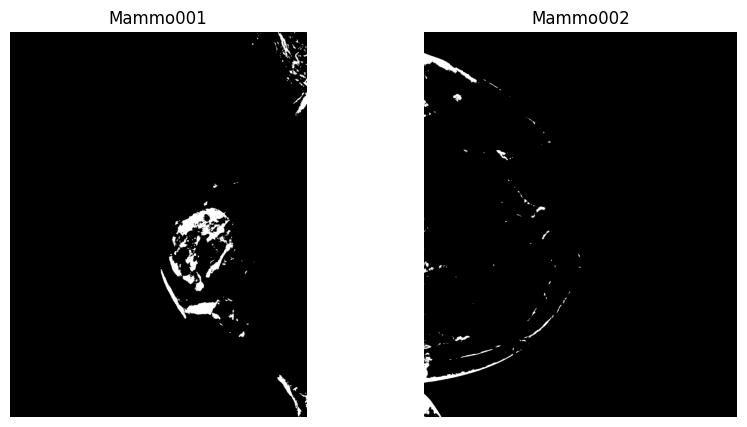

In [5]:
def get_bboxes(img: np.ndarray) -> list[tuple[int, int, int, int]]:
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Sort according to the area of contours in descending order.
    sorted_cnt = sorted(contours, key=cv.contourArea, reverse=True)
    # Remove max area, outermost contour.
    sorted_cnt.remove(sorted_cnt[0])
    bboxes = []
    for cnt in sorted_cnt:
        x, y, w, h = cv.boundingRect(cnt)
        bboxes.append((x, y, w, h))
        
    return bboxes

kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))

image1_gray_threshold = cv.threshold(cv.cvtColor(image1, cv.COLOR_BGR2GRAY), 100, 255, cv.THRESH_BINARY)[1]
image1_gray_threshold = cv.morphologyEx(image1_gray_threshold, cv.MORPH_OPEN, kernel)
image1_auto_box_list = get_bboxes(image1_gray_threshold)
image2_gray_threshold = cv.threshold(cv.cvtColor(image2, cv.COLOR_BGR2GRAY), 100, 255, cv.THRESH_BINARY)[1]
image2_gray_threshold = cv.morphologyEx(image2_gray_threshold, cv.MORPH_OPEN, kernel)
image2_auto_box_list = get_bboxes(image2_gray_threshold)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_gray_threshold, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Mammo001')
ax[1].imshow(image2_gray_threshold, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Mammo002')
plt.show()

In [6]:
print(f'Automatically annotated boxes for Mammo001: {len(image1_auto_box_list)}')
print(f'Automatically annotated boxes for Mammo002: {len(image2_auto_box_list)}')

Automatically annotated boxes for Mammo001: 231
Automatically annotated boxes for Mammo002: 161


As we can see there are a lot of boxes detected in the image. We can filter out the boxes that are too small or too large to be a bounding box for the lesion. We can also filter out the boxes that are too close to each other. We can use the following criteria to filter out the boxes:

In [7]:
def filter_boxes(boxes: list[tuple[int, int, int, int]], min_area: int, max_area: int, min_distance: int) -> list[tuple[int, int, int, int]]:
    filtered_boxes = []
    for box in boxes:
        x, y, w, h = box
        if w * h < min_area or w * h > max_area:
            continue
        if len(filtered_boxes) == 0:
            filtered_boxes.append(box)
        else:
            for fbox in filtered_boxes:
                fx, fy, fw, fh = fbox
                if abs(x - fx) < min_distance and abs(y - fy) < min_distance:
                    break
            else:
                filtered_boxes.append(box)
    return filtered_boxes

image1_auto_box_list = filter_boxes(image1_auto_box_list, min_area=1_000, max_area=50_000, min_distance=50)
image2_auto_box_list = filter_boxes(image2_auto_box_list, min_area=1_000, max_area=50_000, min_distance=50)

print(f'Filtered automatically annotated boxes for Mammo001: {len(image1_auto_box_list)}')
print(f'Filtered automatically annotated boxes for Mammo002: {len(image2_auto_box_list)}')

Filtered automatically annotated boxes for Mammo001: 18
Filtered automatically annotated boxes for Mammo002: 14


Now we can draw the filtered boxes on the images.

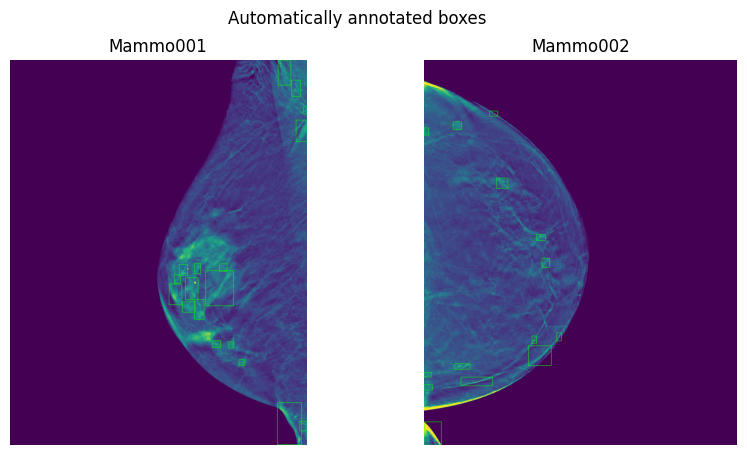

In [8]:
image1_auto_box = image1.copy()
for i, box in enumerate(image1_auto_box_list):
    image1_auto_box = draw_boxes(image1_auto_box, (box[0], box[1]), box[2], box[3])
    
image2_auto_box = image2.copy()
for i, box in enumerate(image2_auto_box_list):
    image2_auto_box = draw_boxes(image2_auto_box, (box[0], box[1]), box[2], box[3])

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(image1_auto_box, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Mammo001')
ax[1].imshow(cv.cvtColor(image2_auto_box, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Mammo002')
plt.suptitle('Automatically annotated boxes')
plt.show()